# <font size="6">Segmentation inference on ANY Slide (all sections of tissue will be used)</font>

### <font size="5">Load model and define transforms</font>

In [1]:
from fastai.basics import *
from fastai.vision import *
from fastai.vision.core import *
from fastai.vision.data import *
from fastai.vision import models
from fastai.vision.all import *
from fastai.metrics import *
from fastai.data.all import *
from fastai.callback import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from albumentations import ShiftScaleRotate, CoarseDropout, Cutout
from albumentations import Compose

In [2]:
model_name = 'deeplabv3+_resnet50_Aug_25_20x_bin_1e-05' # best binary model
# model_name = 'hrnet_hrnet_w30_Aug_25_20x_1e-05' # best multiclass model
torch.cuda.set_device('cuda:0')

In [3]:
class TargetMaskConvertTransform(ItemTransform):
    def __init__(self): 
        pass
    def encodes(self, x):
        img,mask = x
        
        #Convert to array
        mask = np.array(mask)

        # Dataset v2
        mask[mask == 29] = 1
        mask[mask == 71] = 2
        mask[mask == 99] = 3
        mask[mask == 106] = 4
        mask[mask == 111] = 5
        mask[mask == 118] = 6
        mask[mask == 146] = 7
        mask[mask == 154] = 8
        mask[mask == 158] = 9
        mask[mask == 172] = 10
        mask[mask == 178] = 11
        mask[mask == 195] = 12
        mask[mask == 212] = 13
        mask[mask == 223] = 14
        mask[mask == 233] = 15
        mask[mask == 237] = 16
        
        # Back to PILMask
        mask = PILMask.create(mask)
        
        return img, mask
    
class TargetMaskConvertTransformBinary(ItemTransform):
    def __init__(self): 
        pass
    def encodes(self, x):
        img,mask = x
        
        #Convert to array
        mask = np.array(mask)
        
        # Change all non-zero values for 1
        mask[mask == 29] = 1
        mask[mask == 71] = 1
        mask[mask == 99] = 1
        mask[mask == 106] = 1
        mask[mask == 111] = 1
        mask[mask == 118] = 1
        mask[mask == 146] = 1
        mask[mask == 154] = 1
        mask[mask == 158] = 1
        mask[mask == 172] = 1
        mask[mask == 178] = 1
        mask[mask == 195] = 1
        mask[mask == 212] = 1
        mask[mask == 223] = 1
        mask[mask == 233] = 1
        mask[mask == 237] = 1

        # Back to PILMask
        mask = PILMask.create(mask)
        
        return img, mask

In [4]:
class SegmentationAlbumentationsTransform(ItemTransform):
    split_idx = 0
    def __init__(self, aug): self.aug = aug
    def encodes(self, x):
        img,mask = x
        aug = self.aug(image=np.array(img), mask=np.array(mask))
        return PILImage.create(aug["image"]), PILMask.create(aug["mask"])

In [5]:
# def PredsToMasks(mask):        
    #Dataset v2
#     mask[mask == 1] = 29
#     mask[mask == 2] = 71
#     mask[mask == 3] = 99
#     mask[mask == 4] = 106
#     mask[mask == 5] = 111
#     mask[mask == 6] = 118
#     mask[mask == 7] = 146
#     mask[mask == 8] = 154
#     mask[mask == 9] = 158
#     mask[mask == 10] = 172
#     mask[mask == 11] = 178
#     mask[mask == 12] = 195
#     mask[mask == 13] = 212
#     mask[mask == 14] = 223
#     mask[mask == 15] = 233
#     mask[mask == 16] = 237
    
    # return(np.uint8(mask)) # returns np.uint8 array that will be used to create a .png mask


def PredsToMasksBinary(mask):    
    #Dataset v2
    mask[mask == 1] = 1
    
    return(np.uint8(mask)) # returns np.uint8 array that will be used to create a .png mask

In [6]:
# save predictions as masks
def SavePredsMasks(preds, tile_name, save_dir):
    for i, pred in enumerate(preds[1]):
        tile_name = Path(tile_name)

        pred_arg = pred.argmax(dim=0).numpy()
        pred_conv = PredsToMasksBinary(pred_arg) # convert to custom QuPath luminosity values
        
        # save only masks with predictions
        if pred_conv.any() == True:            
            pred_mask = Image.fromarray(pred_conv, 'L')
            save_dir = save_dir

            mask_f = Path(save_dir/tile_name.parent)
            
            mask_f.mkdir(parents=True, exist_ok=True)
            new_name = str(mask_f/tile_name.name) 
            
            pred_mask.save(new_name)

In [7]:
## custom accuracy metric (excludes void code aka 'Background')
def acc_follicle(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    a = TensorImage(target[mask])
    return (input.argmax(dim=1)[mask]==a).float().mean()

In [8]:
learn = load_learner('/media/14TB/aarlova_ovarian/segmentation/training_log/' + model_name + '.pkl', cpu=False)

/home/aarlova/anaconda3/envs/ovarian_fastai/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [9]:
#the dataset, and dls (needed for inference)
foll = pd.read_csv('/media/14TB/aarlova_ovarian/20x_norm_dgx.csv')
segdata = DataBlock(blocks=(ImageBlock),splitter=ColSplitter(),get_x=ColReader('img'),batch_tfms=[Normalize.from_stats(*imagenet_stats), IntToFloatTensor(div_mask = 1)])
dls=segdata.dataloaders(foll,bs=6)

In [10]:
dls.device = default_device()
print(dls.device)

cuda:0


### <font size="5">Load and define image processing modules</font>

In [11]:
import openslide
import cv2
from skimage import morphology
import cv2 as cv
from shapely.geometry import Polygon, MultiPolygon, box
from shapely.ops import unary_union
import matplotlib.pyplot as plt
import random
import numpy as np
from shapely.strtree import STRtree
from shapely.geometry import mapping
from pathlib import Path

plt.rcParams['figure.dpi'] = 200 # for high resolution figure

In [12]:
#################################
def simple_get_mask(img):
    gray = cv2.cvtColor(np.asarray(img), cv2.COLOR_RGB2GRAY)
    _, mask = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU) # threshold using the OTSU method
    mask = morphology.remove_small_objects(mask == 0, min_size=1000, connectivity=2)
    mask = morphology.remove_small_holes(mask, area_threshold=100)
    mask = morphology.binary_dilation(mask, morphology.disk(5))
    return mask

# check for artifacts of slide scanning (horizontal or vertical thin dark strips)
def is_artifact(minx, miny, maxx, maxy):
    x_to_y = (maxx-minx)/(maxy-miny)
    y_to_x = (maxy-miny)/(maxx-minx)
    # print('x_to_y ratio:', int(x_to_y), ', y_to_x ratio:', int(y_to_x))
    if x_to_y > 30 or y_to_x > 30:
        return True
    else:
        return False

# translate thumbnail-relative coords of Polygon to WSI-relative coords
def translate_coords(polys, thumbnail_downsample_factor):
    regions = []
    if polys.type == 'MultiPolygon':
        for i in range(len(polys.geoms)):
            new_ext_x = np.array(polys.geoms[i].exterior.coords.xy[0])*thumbnail_downsample_factor
            new_ext_y = np.array(polys.geoms[i].exterior.coords.xy[1])*thumbnail_downsample_factor
            new_coords = list(zip(new_ext_x, new_ext_y))
            regions.append(new_coords)
    if polys.type == 'Polygon':
        new_ext_x = np.array(polys.exterior.coords.xy[0]) * thumbnail_downsample_factor
        new_ext_y = np.array(polys.exterior.coords.xy[1]) * thumbnail_downsample_factor
        new_coords = list(zip(new_ext_x, new_ext_y))
        regions.append(new_coords)

    return regions

def get_tissue_regions(mask, thumbnail_downsample_factor):
    wsi_thumb_mask = mask.astype(np.uint8)

    contours, hierarchy = cv.findContours(wsi_thumb_mask, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

    contours = [np.squeeze(i) for i in contours]  # removing redundant dimensions
    tissue_regions = [Polygon(i) for i in contours]

    tissue_regions = unary_union(tissue_regions)

    if tissue_regions.type == 'MultiPolygon':
        no_artifacts = MultiPolygon([geom for geom in tissue_regions.geoms if is_artifact(*geom.bounds) == False])
        tissue_regions = no_artifacts

    print('done cleaning')

    # visualize the resulting tissue_regions
    fig, axs = plt.subplots()
    axs.set_aspect('equal', 'datalim')
    axs.invert_yaxis()

    if tissue_regions.type == 'MultiPolygon':
        for geom in tissue_regions.geoms:
            xs, ys = geom.exterior.xy
            axs.plot(xs, ys, color='b', linestyle='-', linewidth=0.3)
    else:
        # for geom in tissue_regions:
        xs, ys = tissue_regions.exterior.xy
        axs.plot(xs, ys, color='b', linestyle='-', linewidth=0.3)

    plt.show()
    plt.cla()
    plt.clf()
    plt.close()

    translated_tissue_regions = translate_coords(tissue_regions, thumbnail_downsample_factor) # These are sections of tissue on the slide

    print('done translating')

    return translated_tissue_regions


def get_grid(polys, tile_size, ol, plot = False):
    slide_patches = []
    for i in range(len(polys)):
        margin_poly = Polygon(polys[i])
        minx, miny, maxx, maxy = margin_poly.bounds
        minx, miny, maxx, maxy = int(minx), int(miny), int(maxx), int(maxy)

        n_cols = int(np.ceil((maxx - minx) / (tile_size - ol)))
        n_rows = int(np.ceil((maxy - miny) / (tile_size - ol)))

        # all x's
        x_zero = int(margin_poly.bounds[0])
        xs = []
        xs.append(x_zero)
        for x in range(n_cols - 1):
            next_x = x_zero + (tile_size - ol)
            xs.append(next_x)
            x_zero = next_x

        # all y's
        y_zero = int(margin_poly.bounds[1])
        ys = []
        ys.append(y_zero)
        for y in range(n_rows - 1):
            next_y = y_zero + (tile_size - ol)
            ys.append(next_y)
            y_zero = next_y

        # assemble into rectangles
        patches = []
        for w in range(n_cols):
            x = xs[w]
            for z in range(n_rows):
                y = ys[z]
                rect = box(x, y, x + tile_size, y + tile_size, ccw=False)
                patches.append(rect)

        # find patches that intersect with tissue margin
        tree = STRtree(patches)
        query_geom = margin_poly
        intersects = [n for n in tree.query(query_geom) if n.intersects(query_geom) and n.intersection(query_geom).area/n.area > 0.05]

        # print('number of patches in this section: ', len(intersects))

        # append intersecting patches to slide_patches list
        slide_patches.append(intersects)

        if plot == True:
            # let's plot the intersecting ones
            fig, ax = plt.subplots()

            # plot main_poly
            ab = margin_poly.exterior.xy
            a, b = np.array(ab[0]), np.array(ab[1])
            ax.plot(a, b, color='b', linestyle='-', linewidth=0.4)
            ax.invert_yaxis()

            # plot other_polies
            patches = intersects
            color = ['r', 'g', 'b', 'c', 'y', 'm']
            for j in range(len(patches)):
                x, y = np.array(patches[j].exterior.xy[0]), np.array(patches[j].exterior.xy[1])
                plt.plot(x, y, color=color[random.randint(0, 5)], linestyle='-', linewidth=0.4)
            ax.grid(linestyle='--', linewidth='0.5')
            plt.title("Finding Intersecting Polys")
            plt.xlabel("X")
            plt.ylabel("Y")
            plt.axis('equal')
            plt.show()
            plt.cla()
            plt.clf()
            plt.close()

    return slide_patches

### <font size="5">Define Inference settings (Magnification, Tile Size, Save directory, etc) </font>

In [13]:
save_dir = '/media/14TB/aarlova_ovarian/SH_demo/output/seg_masks/'
save_dir

'/media/14TB/aarlova_ovarian/SH_demo/output/seg_masks/'

In [14]:
requested_magn = 20
downsample = int(40/requested_magn) # Use 4 for 10x, 2 for 20x, 1 for 40x
tile_size = int(500*downsample) # Use 2000 for 10x, 1000 for 20x, 500 for 40x
overlap = int(250*downsample)
print('downsample',downsample, 'tile_size', tile_size, 'overlap', overlap)

downsample 2 tile_size 1000 overlap 500


In [15]:
slide_dir = '/media/14TB/aarlova_ovarian/SH_demo/input/'

slide_list = ['17133893']

### <font size="5">Run Inference!</font>

Working on Slide /media/14TB/aarlova_ovarian/SH_demo/input/17133893.svs
opened slide!


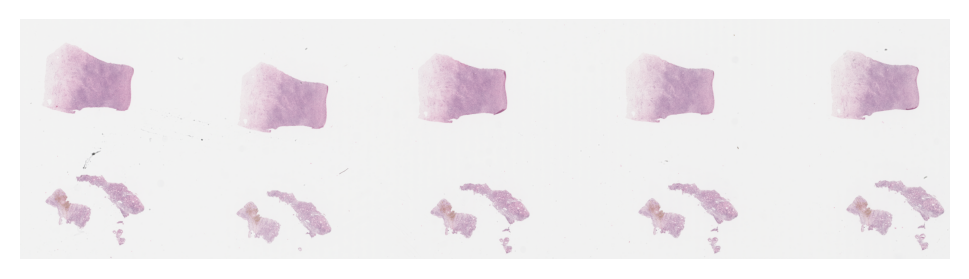

done cleaning


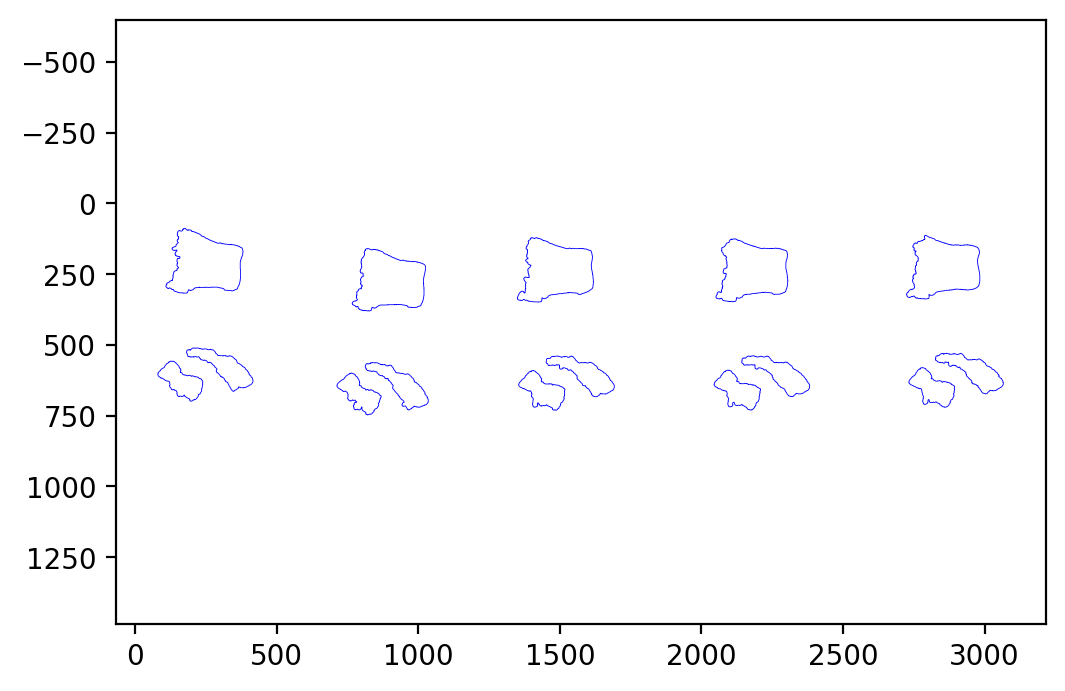

done translating
Set tile size to 1000 , and overlap to 500
Done tiling the slide!
Number of sections in slide: 15
Number of tiles in current section: 786
done processing tiles in section 0
Number of tiles in current section: 750
done processing tiles in section 1
Number of tiles in current section: 288
done processing tiles in section 2
Number of tiles in current section: 233
done processing tiles in section 3
Number of tiles in current section: 295
done processing tiles in section 4
Number of tiles in current section: 249
done processing tiles in section 5
Number of tiles in current section: 233
done processing tiles in section 6
Number of tiles in current section: 752
done processing tiles in section 7
Number of tiles in current section: 783
done processing tiles in section 8
Number of tiles in current section: 748
done processing tiles in section 9
Number of tiles in current section: 292
done processing tiles in section 10
Number of tiles in current section: 293
done processing til

In [16]:
for i in range(len(slide_list)):
    slide_fname = Path(slide_dir + '/' + slide_list[i] + '.svs')
    print('Working on Slide', slide_fname)

    slide = openslide.OpenSlide(str(slide_fname))
    print('opened slide!')
    levels = int(slide.level_count)
    thumb_dim = slide.level_dimensions[levels - 1]  # highest level corresponds to smallest available dimension
    thumbnail_downsample_factor = int(slide.level_downsamples[levels - 1])  # corresponding downsample factor of the thumbnail to be produced

    wsi_thumb = slide.get_thumbnail(thumb_dim)
    plt.imshow(wsi_thumb)
    plt.axis('off')
    plt.show()
    plt.cla()
    plt.clf()
    plt.close()

    wsi_thumbnail_mask = simple_get_mask(wsi_thumb)

    tissue_regions = get_tissue_regions(wsi_thumbnail_mask, thumbnail_downsample_factor)
    

    #######################################################################
    # generate a grid of tiles of specific size and overlap within bounds of the Ovary
    print('Set tile size to', tile_size, ', and overlap to', overlap)
    slide_grid = get_grid(tissue_regions, tile_size, overlap, plot=False) # slide_grid is a nested list of Polygons. Len(slide_grid) is how many sections of tissue are on slide.
    print('Done tiling the slide!')
    
    #######################################################################
    ### get predictions for each tile
    print('Number of sections in slide:', len(slide_grid))

    for section in range(len(slide_grid)):
        print('Number of tiles in current section:', len(slide_grid[section]))


        for tile in range(len(slide_grid[section])):
            current_tile = slide_grid[section][tile]
            current_tile_top_left_coord = [int(current_tile.bounds[0]), int(current_tile.bounds[1])]  # this should be minx, miny if polygons were created with ccw=False
            tile_name = str(slide_fname.stem) + '/' + str(slide_fname.stem) + ' [x=' + str(current_tile_top_left_coord[0]) + ',y=' + str(current_tile_top_left_coord[1]) + ',w='+str(tile_size) + ',h=' + str(tile_size) + '].png'
            tile_img = slide.read_region((current_tile_top_left_coord[0], current_tile_top_left_coord[1]),0,(tile_size,tile_size)).convert('RGB')
            resized_tile = tile_img.resize((500,500))
            resized_tile_arr = np.asarray(resized_tile)

            ### Predict on one individual tile at a time and Save predicted masks

            test_dl = dls.test_dl([resized_tile_arr], with_labels = False)
            
            with learn.no_bar():
                preds = learn.get_preds(dl=test_dl, with_input = True)
            SavePredsMasks(preds, tile_name, save_dir)


            tile_img.close()
            resized_tile.close()

        print('done processing tiles in section', section)
    print('done with all sections')

    slide.close()


# <font size="6">Convert Segmentation Masks to JSON</font>

In [49]:
# ###### AI predicted masks to JSON (3/14 version)
import ovarian_utils
from ovarian_utils import MetaPolygon
from ovarian_utils import write_qupath_noIDs
from ovarian_utils import get_AI_regions
from pathlib import Path
import numpy as np
from shapely.ops import unary_union
from collections.abc import Iterable



In [50]:
# ##### Dataset v2

# label_dict = {29: 'Corpus Luteum', 50: 'Ovulated Antral Follicle', 61: 'Secondary No Nuclei', 63: 'Pre-Selection Antral', 71: 'Primary', 95: 'Atretic Antral with AM', 99: 'Atretic Antral with NM', 106: 'AMF-G', 111: 'AMF-O', 118: 'Multilayer', 124: 'Transitional', 126: 'Multilayer No Oocyte', 146: 'do not count', 154: 'Primordial', 158: 'Transitional Primordial', 165: 'Large Antral', 171: 'Transforming Primary', 172: 'Transitional Primary', 178: 'Ovulatory Antral', 195: 'Small Antral', 211: 'NOS', 212: 'Multi-oocytic', 219: 'Selection Antral', 223: 'AMF-OG', 225: 'Antral', 226: 'Intermediate Antral', 233: 'Secondary', 237: 'Early Antral'}
# region_colors = {'Antral': -3348737, 'Corpus Luteum': -16770432, 'Intermediate Antral': 13368731, 'Large Antral': -32640, 'Multilayer No Oocyte': 3448731, 'NOS': -77704, 'Ovulated Antral Follicle': -12711951, 'Primary': -5039590, 'Primordial': -13441998, 'Secondary': -3342388, 'Secondary No Nuclei': -9568001, 'Small Antral': -5116141, 'Transforming Primary': -5718196, 'Transitional': 3181811, 'do not count': -1547353, 'AMF-O': -10777334, 'AMF-G': -10787154, 'AMF-OG': -202146, 'Pre-Selection Antral': -14007201, 'Ovulatory Antral': -5981266, 'Transitional Primordial': -10832165, 'Dominance Antral': -3361793, 'Transitional Primary': -6895274, 'Early Antral': -199768, 'Selection Antral': -6751006, 'Multi-oocytic': -1644979, 'Atretic Antral with NM': -7653406, 'Atretic Antral with AM': -12756516, 'Multilayer': -16274801}

# ####### Label Dictionary for Binary masks
label_dict = {1: 'Follicle'}
region_colors = {'Follicle': -3348737}

master_dir = Path('/media/14TB/aarlova_ovarian/SH_demo/output/seg_masks/')
json_save_dir = '/media/14TB/aarlova_ovarian/SH_demo/output/'

###############

min_area = 5000

###############

for dir in master_dir.iterdir():
    if dir.is_dir():
        mask_dir = dir
        print(mask_dir)
        json_save = json_save_dir + str(mask_dir.stem) + '.json'
        print('Working on creating', json_save)

        AI_slide_polygons = get_AI_regions(mask_dir)
        AI_slide_labels = np.unique([p.label for p in AI_slide_polygons])

        regions = []
        region_labels = []

        for label in AI_slide_labels:
            print('Detected class', label)
            if label == 'Antral':
                buffer = 1.5
                current_label_polygons = [p.buffer(buffer) for p in AI_slide_polygons if (p.label == label and p.area > 50000)]
            else:
                buffer = 1.5
                # find all polys with this label and unary_union them
                current_label_polygons = [p.buffer(buffer) for p in AI_slide_polygons if (p.label == label and p.area > min_area)]
            print('detected before union',len(current_label_polygons))

            # unary_union on polygons of the same label
            if len(current_label_polygons) > 1:
                current_label_polygons_union = unary_union(current_label_polygons)

                if not isinstance(current_label_polygons_union, Iterable):
                    current_label_polygons_union = [current_label_polygons_union]

                current_label_polygons_union_with_label = [MetaPolygon(label, p) for p in current_label_polygons_union]

                # convert to regions and regions_labels
                for p in current_label_polygons_union_with_label:
                    new_ext_x = np.array(p.exterior.coords.xy[0])
                    new_ext_y = np.array(p.exterior.coords.xy[1])

                    new_coords = list(zip(new_ext_x, new_ext_y))
                    new_label = p.label
                    regions.append(new_coords)
                    region_labels.append(new_label)
                print('detected after union', len(current_label_polygons_union_with_label))

            elif len(current_label_polygons) == 0:
                pass

            else:
                new_ext_x = np.array(current_label_polygons[0].exterior.coords.xy[0])
                new_ext_y = np.array(current_label_polygons[0].exterior.coords.xy[1])

                new_coords = list(zip(new_ext_x, new_ext_y))
                new_label = label
                regions.append(new_coords)
                region_labels.append(new_label)

        ids = [i for i in range(len(regions))]
        write_qupath_noIDs(json_save, regions,region_labels,region_colors)
        print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

/media/14TB/aarlova_ovarian/SH_demo/output/seg_masks/17133893
Working on creating /media/14TB/aarlova_ovarian/SH_demo/output/17133893.json
This folder has predictions


KeyError: 1